<a href="https://colab.research.google.com/github/Sercan1111/Car-Detection-Using-YOLOV5/blob/main/Car_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install opencv-python
!pip install numpy
!pip install matplotlib


In [ ]:
!pip install imageai --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 2.5 MB/s eta 0:00:00


In [1]:
import pandas as pd
train_bboxes = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/data/train_solution_bounding_boxes (1).csv')
print(train_bboxes.head())
sample_submission  = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/data/sample_submission.csv')
print(sample_submission.head())


             image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
             image                           bounds
0  vid_5_26560.jpg  0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0
1  vid_5_26580.jpg  0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0
2  vid_5_26600.jpg                  0.0 0.0 1.0 1.0
3  vid_5_26620.jpg                  0.0 0.0 1.0 1.0
4  vid_5_26640.jpg                  0.0 0.0 1.0 1.0


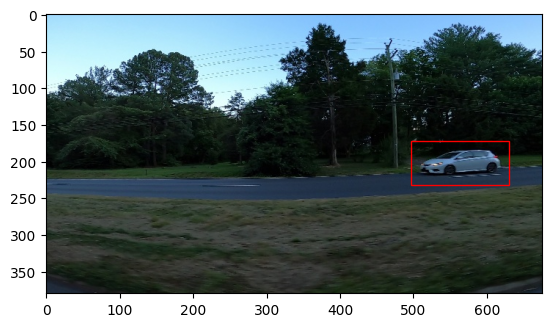

In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_image_with_boxes(df, img_path, img_name):
    # Doğru dosya yolu oluşturma
    full_path = img_path + '/' + img_name
    img = cv2.imread(full_path)
    if img is None:
        print("Image not found:", full_path)
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR'den RGB'ye dönüştür

    # 'filename' sütunu varsa ve doğru isimle filtreleme
    if 'image' in df.columns:
        bounding_boxes = df[df['image'] == img_name]
    else:
        print("No 'filename' column in DataFrame")
        return

    # Görseli oluştur
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Sınırlayıcı kutuları ekle
    for index, row in bounding_boxes.iterrows():
        rect = patches.Rectangle((row['xmin'], row['ymin']), row['xmax'] - row['xmin'], row['ymax'] - row['ymin'], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Örnek kullanım
show_image_with_boxes(train_bboxes, '/content/drive/MyDrive/Colab_Notebooks/data/train_images/', 'vid_4_10020.jpg')


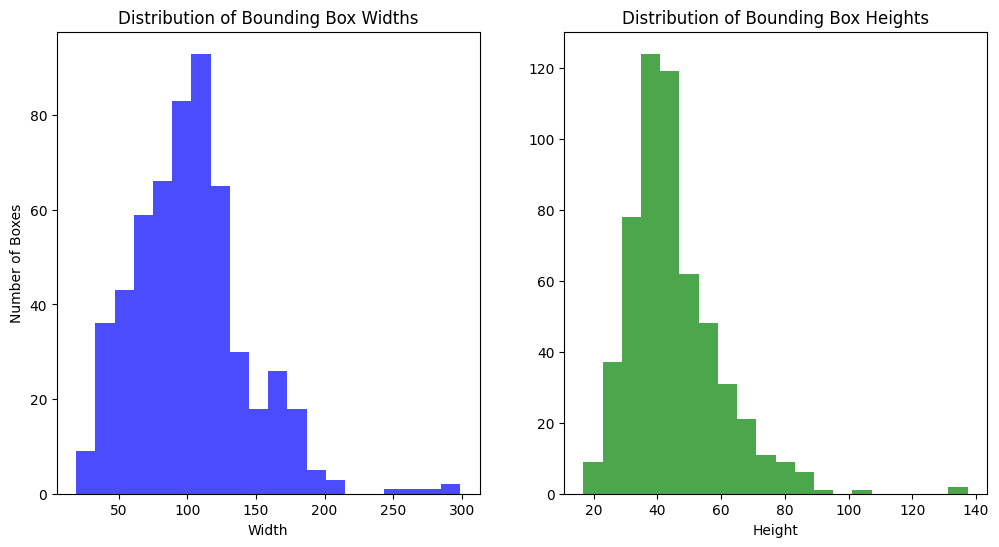

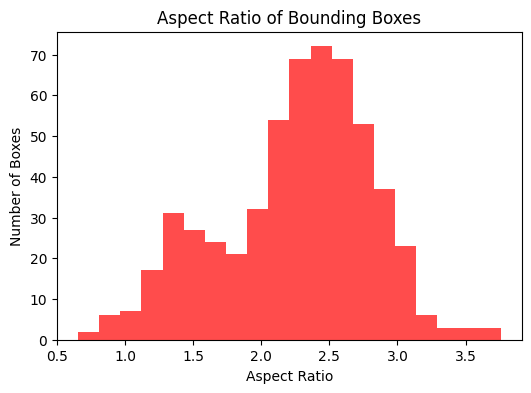

In [3]:
# Analyze the Distribution of Object Sizes and Aspect Ratios
#Understanding the size and aspect of bounding boxes can help to tailor the model
# Calculate width, height and aspect ratio
train_bboxes['width'] = train_bboxes['xmax'] - train_bboxes['xmin']
train_bboxes['height'] = train_bboxes['ymax'] - train_bboxes['ymin']
train_bboxes['aspect_ratio'] = train_bboxes['width'] / train_bboxes['height']

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(train_bboxes['width'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width')
plt.ylabel('Number of Boxes')

plt.subplot(1, 2, 2)
plt.hist(train_bboxes['height'], bins=20, color='green', alpha=0.7)
plt.title('Distribution of Bounding Box Heights')
plt.xlabel('Height')

plt.show()

# Aspect ratio
plt.figure(figsize=(6, 4))
plt.hist(train_bboxes['aspect_ratio'], bins=20, color='red', alpha=0.7)
plt.title('Aspect Ratio of Bounding Boxes')
plt.xlabel('Aspect Ratio')
plt.ylabel('Number of Boxes')
plt.show()


In [4]:
# Using describe to get statistical insights
print(train_bboxes[['width', 'height', 'aspect_ratio']].describe())


            width      height  aspect_ratio
count  559.000000  559.000000    559.000000
mean   101.937359   44.982933      2.256474
std     41.213744   14.445924      0.557860
min     19.076700   16.735751      0.654660
25%     73.360524   35.701416      1.928674
50%     99.785818   42.059202      2.344855
75%    122.041968   51.840412      2.644883
max    298.868307  137.425997      3.758234


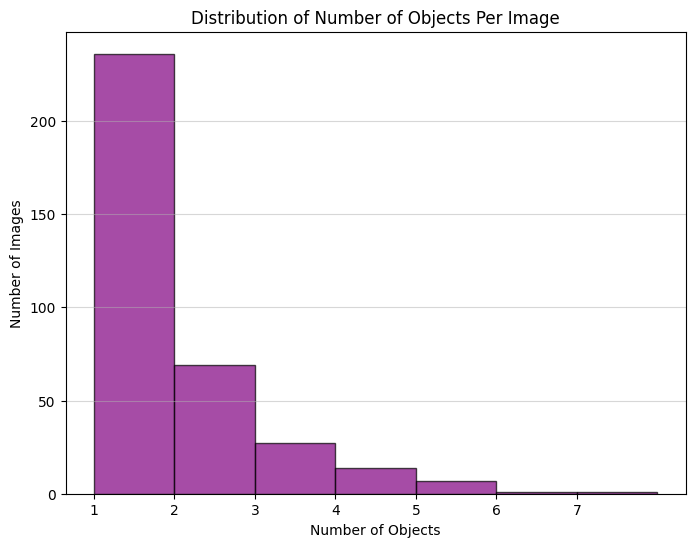

count    355.000000
mean       1.574648
std        1.006717
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        7.000000
dtype: float64


In [5]:
# Distribution of number of objects per image
num_objects_per_image = train_bboxes.groupby('image').size()

plt.figure(figsize=(8, 6))
plt.hist(num_objects_per_image, bins=range(1, num_objects_per_image.max() + 2), color='purple', alpha=0.7, edgecolor='black')
plt.title('Distribution of Number of Objects Per Image')
plt.xlabel('Number of Objects')
plt.ylabel('Number of Images')
plt.xticks(range(1, num_objects_per_image.max() + 1))
plt.grid(axis='y', alpha=0.5)
plt.show()

# Statistical summary
print(num_objects_per_image.describe())


In [ ]:
# Check for any missing values in the DataFrame
missing_data = train_bboxes.isnull().sum()
print("Missing values in each column:\n", missing_data)
# Identify outliers in 'width' and 'height'
q1 = train_bboxes[['width', 'height']].quantile(0.25)
q3 = train_bboxes[['width', 'height']].quantile(0.75)
iqr = q3 - q1

# Define bounds for what you consider an outlier
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter outliers
outliers = train_bboxes[(train_bboxes['width'] < lower_bound['width']) |
                        (train_bboxes['width'] > upper_bound['width']) |
                        (train_bboxes['height'] < lower_bound['height']) |
                        (train_bboxes['height'] > upper_bound['height'])]
print("Detected outliers:\n", outliers)

# Optionally plot an image with outliers to visually inspect
for index, row in outliers.iterrows():
    show_image_with_boxes(train_bboxes, '/content/drive/MyDrive/Colab_Notebooks/data/training_images', row['image'])

# Calculate and print correlation matrix
correlation_matrix = train_bboxes[['width', 'height']].corr()
print("Correlation matrix:\n", correlation_matrix)


Missing values in each column:
 image           0
xmin            0
ymin            0
xmax            0
ymax            0
width           0
height          0
aspect_ratio    0
dtype: int64
Detected outliers:
                image        xmin        ymin        xmax        ymax  \
57   vid_4_12300.jpg  415.774240  169.428893  586.975398  254.525418   
63   vid_4_12340.jpg   95.383502  177.742921  240.170767  259.905084   
67   vid_4_12480.jpg   22.500724  166.494530  309.629522  303.920528   
84   vid_4_13740.jpg  232.344428  174.808559  423.600579  252.569176   
90   vid_4_13780.jpg  400.121563  148.399292  561.539797  235.452059   
105  vid_4_14140.jpg  343.869754  182.144466  616.324168  285.825290   
106  vid_4_14160.jpg    0.000000  194.860039  161.907381  279.956564   
148  vid_4_17320.jpg  262.182344  176.764801  561.050651  308.322072   
149  vid_4_17340.jpg    0.000000  190.947555  133.536903  279.467503   
174   vid_4_1800.jpg  141.363242  178.721043  322.347323  258.437902   

In [ ]:
!pip install imgaug


In [ ]:
import imgaug.augmenters as iaa

# Define an augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # 50% chance to flip images horizontally
    iaa.Affine(
        rotate=(-10, 10),  # rotate images between -10 and 10 degrees
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}  # scale images between 80% and 120%
    ),
    iaa.Multiply((0.9, 1.1))  # change brightness between 90% and 110%
])


In [ ]:
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import imageio.v2 as imageio

def load_image_and_bboxes(image_path, bboxes_df):
    image = imageio.imread(image_path)
    bboxes = BoundingBoxesOnImage([
        BoundingBox(x1=row['xmin'], y1=row['ymin'], x2=row['xmax'], y2=row['ymax'])
        for _, row in bboxes_df.iterrows()
    ], shape=image.shape)
    return image, bboxes

def augment_image_and_bboxes(image, bboxes, seq):
    image_aug, bboxes_aug = seq(image=image, bounding_boxes=bboxes)
    bboxes_aug = bboxes_aug.remove_out_of_image().clip_out_of_image()
    return image_aug, bboxes_aug

# Example usage:
image_path = '/content/drive/MyDrive/Colab_Notebooks/data/training_images/vid_4_12300.jpg'
bboxes_df = train_bboxes[train_bboxes['image'] == 'vid_4_12300.jpg']

image, bboxes = load_image_and_bboxes(image_path, bboxes_df)
image_aug, bboxes_aug = augment_image_and_bboxes(image, bboxes, seq)

# Now, you can visualize or save the augmented image and its bboxes


FileNotFoundError: No such file: '/content/drive/MyDrive/Colab_Notebooks/data/training_images/vid_4_12300.jpg'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_image_with_bboxes(image, bboxes, ax, title="Image"):
    """Visualize an image with its bounding boxes on a given Matplotlib axis."""
    ax.imshow(image)
    for bbox in bboxes.bounding_boxes:
        rect = patches.Rectangle((bbox.x1, bbox.y1), bbox.width, bbox.height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.set_title(title)
    ax.axis('off')

def compare_original_and_augmented(image_path, bboxes_df, seq):
    # Load and augment the image and bounding boxes
    image, bboxes = load_image_and_bboxes(image_path, bboxes_df)
    image_aug, bboxes_aug = augment_image_and_bboxes(image, bboxes, seq)

    # Create plot to show original and augmented images side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    visualize_image_with_bboxes(image, bboxes, ax1, title="Original Image")
    visualize_image_with_bboxes(image_aug, bboxes_aug, ax2, title="Augmented Image")
    plt.show()


In [ ]:
# Example usage:
image_path = '/content/drive/MyDrive/Colab_Notebooks/data/training_images/vid_4_1020.jpg'
bboxes_df = train_bboxes[train_bboxes['image'] == 'vid_4_1020.jpg']
compare_original_and_augmented(image_path, bboxes_df, seq)


FileNotFoundError: No such file: '/content/drive/MyDrive/Colab_Notebooks/data/training_images/vid_4_1020.jpg'

In [ ]:
import os
def normalize_bboxes(df, img_folder):
    data = []  # List to store normalized data entries

    for _, row in df.iterrows():
        img_path = os.path.join(img_folder, row['image'])
        with Image.open(img_path) as img:
            width, height = img.size

        # Normalize the bounding box coordinates
        x_center = (row['xmin'] + (row['xmax'] - row['xmin']) / 2) / width
        y_center = (row['ymin'] + (row['ymax'] - row['ymin']) / 2) / height
        norm_width = (row['xmax'] - row['xmin']) / width
        norm_height = (row['ymax'] - row['ymin']) / height

        # Collect each normalized entry as a dictionary
        data.append({
            "image": row['image'],
            "class_id": 0,  # Assuming class_id is 0 for all instances
            "x_center": x_center,
            "y_center": y_center,
            "width": norm_width,
            "height": norm_height
        })

    # Convert list of dictionaries to DataFrame
    normalized_data = pd.DataFrame(data)
    return normalized_data

# Normalize bounding boxes
img_folder = '/content/drive/MyDrive/Colab_Notebooks/data/training_images'
normalized_bboxes = normalize_bboxes(train_bboxes, img_folder)

NameError: name 'Image' is not defined

In [ ]:
# Function to save annotations in YOLO format
def save_annotations(df, annotation_folder):
    grouped = df.groupby('image')
    for name, group in grouped:
        annotation_path = os.path.join(annotation_folder, name.replace('.jpg', '.txt'))
        with open(annotation_path, 'w') as file:
            for _, row in group.iterrows():
                file.write(f"{int(row['class_id'])} {row['x_center']} {row['y_center']} {row['width']} {row['height']}\n")

# Ensure the annotation folder exists
annotation_folder = '/content/drive/MyDrive/Colab_Notebooks/data/annotations'
os.makedirs(annotation_folder, exist_ok=True)

# Save normalized annotations
save_annotations(normalized_bboxes, annotation_folder)

NameError: name 'normalized_bboxes' is not defined

In [6]:
# !pip install -r requirements.txt
# import PIL
# print(PIL.__version__)

!git clone https://github.com/ultralytics/yolov5  # Clone repo
%cd yolov5
!pip install -r requirements.txt  # Install required Python packages

Cloning into 'yolov5'...
remote: Enumerating objects: 16597, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 16597 (delta 39), reused 39 (delta 18), pack-reused 16522
Receiving objects: 100% (16597/16597), 15.13 MiB | 17.51 MiB/s, done.
Resolving deltas: 100% (11396/11396), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.4/756.4 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-n

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set the directory paths
base_dir = '/content/drive/MyDrive/Colab_Notebooks/data'
images_dir = os.path.join(base_dir, 'training_images')
train_dir = os.path.join(base_dir, 'train_images')
val_dir = os.path.join(base_dir, 'val_images')

# Ensure the training and validation directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# List all files in the original images directory and the new training/validation directories
original_images = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
train_images = [f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))]
val_images = [f for f in os.listdir(val_dir) if os.path.isfile(os.path.join(val_dir, f))]

# If the original directory is empty but train and val directories are not, skip splitting
if not original_images and (train_images or val_images):
    print("Training and validation images have already been split.")
else:
    # Split only if original_images is not empty
    if original_images:
        train_images, val_images = train_test_split(original_images, test_size=0.2, random_state=42)
        # Move the files
        def move_images(image_list, src, dst):
            for image in image_list:
                src_path = os.path.join(src, image)
                dst_path = os.path.join(dst, image)
                shutil.move(src_path, dst_path)

        move_images(train_images, images_dir, train_dir)
        move_images(val_images, images_dir, val_dir)
        print("Images successfully split and moved.")
    else:
        print("No images found in the original directory to split and move.")


Training and validation images have already been split.


In [2]:
images = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
print(images)  # Check if this list is actually populated

# # Create or update the dataset.yaml file
# %%writefile /content/drive/MyDrive/Colab_Notebooks/data/dataset.yaml
# train: /content/drive/MyDrive/Colab_Notebooks/data/train_images  # path to training images
# val: /content/drive/MyDrive/Colab_Notebooks/data/val_images  # path to validation images
# nc: 1  # number of classes
# names: ['car']  # class names


[]


In [3]:
%cd /content/yolov5/models
 # This will display the contents of the file


/content/yolov5/models


In [4]:
import os
print(os.getcwd())  # This will show the current working directory
dataset_yaml = """
train: /content/drive/MyDrive/Colab_Notebooks/data/train_images  # path to training images
val: /content/drive/MyDrive/Colab_Notebooks/data/val_images  # path to validation images
nc: 1  # number of classes
names: ['car']  # class names
"""

# Write the dataset.yaml file
with open('/content/yolov5/data/dataset.yaml', 'w') as f:
    f.write(dataset_yaml)


/content/yolov5/models


In [5]:
image_files = set([f for f in os.listdir(train_dir) if f.endswith('.jpg')])
label_files = set([f for f in os.listdir(train_dir) if f.endswith('.txt')])

missing_labels = {f.replace('.jpg', '.txt') for f in image_files} - label_files
print("Images missing labels:", missing_labels)


Images missing labels: set()


In [6]:
!pip install labelImg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 10.9 MB/s eta 0:00:00
  Created wheel for labelImg: filename=labelImg-1.8.6-py2.py3-none-any.whl size=261519 sha256=96814e89d8ecf32b483ed01c216c1d561ab5e754c6964854a30c7028c7851700
  Stored in directory: /root/.cache/pip/wheels/d9/f0/1e/74c509495458cad13a0fda23fe605e643177625cf2b5c17b34
Successfully built labelImg


In [7]:
import os
from PIL import Image

def create_labels(image_folder, output_folder, class_id=0):
    os.makedirs(output_folder, exist_ok=True)
    for image_name in os.listdir(image_folder):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder, image_name)
            image = Image.open(image_path)
            width, height = image.size

            # Example: Assuming a single object centered in each image with a fixed size
            x_center, y_center = width / 2, height / 2
            box_width, box_height = width * 0.5, height * 0.5  # Adjust sizes as per your data

            # Normalize coordinates
            x_center /= width
            y_center /= height
            box_width /= width
            box_height /= height

            # Create label file
            label_path = os.path.join(output_folder, image_name.replace(image_name.split('.')[-1], 'txt'))
            with open(label_path, 'w') as f:
                f.write(f"{class_id} {x_center} {y_center} {box_width} {box_height}\n")

# Usage
image_folder = '/content/drive/MyDrive/Colab_Notebooks/data/train_images'
label_folder = '/content/drive/MyDrive/Colab_Notebooks/data/labels'
create_labels(image_folder, label_folder)


In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data dataset.yaml --cfg models/yolov5l.yaml --weights yolov5l.pt --name yolov5l_car_results


2024-05-10 09:38:54.202113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 09:38:54.202179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 09:38:54.204501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5l.pt, cfg=models/yolov5l.yaml, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, s

In [ ]:
import shutil
import os

# Etiketlerin bulunduğu klasör
labels_dir = '/content/drive/MyDrive/Colab_Notebooks/data/labels'
# Görüntülerin bulunduğu klasör
images_dir = '/content/drive/MyDrive/Colab_Notebooks/data/train_images'

# Etiket dosyalarını taşıyın
for label_file in os.listdir(labels_dir):
    src_path = os.path.join(labels_dir, label_file)
    dst_path = os.path.join(images_dir, label_file)
    shutil.move(src_path, dst_path)  # Etiketleri taşı


In [ ]:
val_images_dir = '/content/drive/MyDrive/Colab_Notebooks/data/val_images'
val_labels = [f for f in os.listdir(val_images_dir) if f.endswith('.txt')]
if not val_labels:
    print("Doğrulama etiket dosyaları bulunamadı.")
else:
    print(f"Doğrulama için {len(val_labels)} etiket dosyası bulundu.")


Doğrulama için 201 etiket dosyası bulundu.


In [ ]:
import os
from PIL import Image

def create_labels(image_folder, output_folder, class_id=0):
    os.makedirs(output_folder, exist_ok=True)
    for image_name in os.listdir(image_folder):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder, image_name)
            image = Image.open(image_path)
            width, height = image.size

            # Örnek: Her görüntüde merkezde sabit boyutta tek bir nesne varsayımı
            x_center, y_center = width / 2, height / 2
            box_width, box_height = width * 0.5, height * 0.5  # Verilerinize göre boyutları ayarlayın

            # Koordinatları normalize et
            x_center /= width
            y_center /= height
            box_width /= width
            box_height /= height

            # Etiket dosyası oluştur
            label_path = os.path.join(output_folder, image_name.replace(image_name.split('.')[-1], 'txt'))
            with open(label_path, 'w') as f:
                f.write(f"{class_id} {x_center} {y_center} {box_width} {box_height}\n")

# Kullanımı
val_image_folder = '/content/drive/MyDrive/Colab_Notebooks/data/val_images'
val_label_folder = '/content/drive/MyDrive/Colab_Notebooks/data/val_images'  # Etiketleri aynı klasöre kaydet
create_labels(val_image_folder, val_label_folder)


In [ ]:
# dataset.yaml dosyasının yolunu belirtin
yaml_file_path = '/content/drive/MyDrive/Colab_Notebooks/data/dataset.yaml'

# dataset.yaml dosyasını aç ve içeriğini yazdır
with open(yaml_file_path, 'r') as file:
    content = file.read()
    print(content)


train: /content/drive/MyDrive/Colab_Notebooks/data/train_images  # path to training images
val: /content/drive/MyDrive/Colab_Notebooks/data/val_images  # path to validation images
nc: 1  # number of classes
names: ['car']  # class names



In [ ]:
import os

# Mevcut çalışma dizinini kontrol et
print("Mevcut çalışma dizini:", os.getcwd())

# Eğer yolov5 klasöründe değilseniz, yolov5 klasörüne geçiş yapın
if 'yolov5' not in os.getcwd():
    %cd yolov5
    print("Yeni çalışma dizini:", os.getcwd())


Mevcut çalışma dizini: /content
/content/yolov5
Yeni çalışma dizini: /content/yolov5


In [ ]:
# YOLOv5 reposunu klonla
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

# Gerekli Python paketlerini yükle
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 16582, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 16582 (delta 30), reused 39 (delta 18), pack-reused 16522
Receiving objects: 100% (16582/16582), 15.13 MiB | 19.63 MiB/s, done.
Resolving deltas: 100% (11387/11387), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.5/756.5 kB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-n

In [ ]:
!python train.py --img 640 --batch 16 --epochs 10 --data /content/drive/MyDrive/Colab_Notebooks/data/dataset.yaml --cfg models/yolov5l.yaml --weights yolov5l.pt --name yolov5l_car_results


2024-05-10 14:27:35.311673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 14:27:35.311733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 14:27:35.430734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5l.pt, cfg=models/yolov5l.yaml, data=/content/drive/MyDrive/Colab_Notebooks/data/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_